# Метод опорных векторов (SVM)

Помимо вероятностного подхода, существует еще геометрический подход: в нем мы предсказываем не вероятность отношения к классу, а разделяющие классы гиперплоскости. Этот подход имеет свои преимущества. Давайте разбираться.



##1D классификация

Вернемся к задаче классификации мышей. Рассмотрим **одномерный пример**. У нас есть данные только по **массе мышей**. Часть из них определена как мыши с нормальной массой тела, а часть — как мыши с ожирением. Данные выглядят например так:

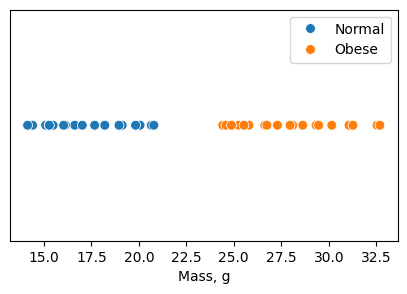

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


custom_cmap = ListedColormap(["#B8E1EC", "#bea6ff", "#FEE7D0"])

def generate_data(total_len=40):
    x = np.hstack(
        [
            np.random.uniform(14, 21, total_len // 2),
            np.random.uniform(24, 33, total_len // 2),
        ]
    )
    y = np.hstack([np.zeros(total_len // 2), np.ones(total_len // 2)])
    return x, y


def plot_data_1d(
    x,
    y,
    total_len=40,
    s=50,
    threshold=None,
    margin=None,
    legend=["Normal", "Obese"],
    marker="o",
):
    ax = sns.scatterplot(x=x, y=np.zeros(len(x)), hue=y, s=s, marker=marker)
    if threshold:
        x_lim, y_lim = ax.get_xlim(), ax.get_ylim()
        XX, YY = np.meshgrid(
            np.linspace(x_lim[0], x_lim[1], 100),
            np.linspace(y_lim[0], y_lim[1], 100),
        )
        pred = np.sign(XX - threshold)
        plt.contourf(XX, YY, pred, alpha=0.3, cmap=custom_cmap)
        ax.axvline(threshold, color="grey")
    if margin:
        for line in margin:
            ax.axvline(line, color="grey", ls="dashed")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, legend)
    ax.set(xlabel="Mass, g", yticks=[])
    return ax


total_len = 40
np.random.seed(42)
x, y = generate_data(total_len=total_len)
plt.figure(figsize=(5, 3))

ax = plot_data_1d(
    x, y, total_len=total_len,
)

В случае если классы разделимы (существует пороговое значение, для которого все точки одного множества/класса расположены с одной стороны, а другого — с другой) - задача решается легко: мы находим мышь с ожирением с минимальной массой $\min({m_\text{obese}})$, мышь без ожирения максимальной массой $\max({m_\text{normal}})$. Порог выбираем посередине:

[]

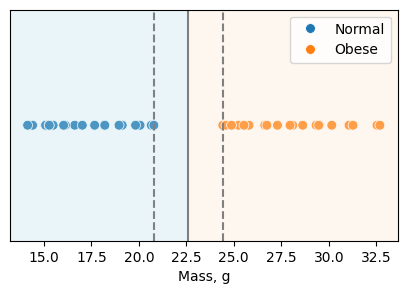

In [ ]:
total_len = 40
np.random.seed(42)
x, y = generate_data(total_len=total_len)
plt.figure(figsize=(5, 3))

normal_limit = x[y == 0].max()  # extreme point for 'normal'
obese_limit = x[y == 1].min()  # extreme point for 'obese'

threshold = np.mean([normal_limit, obese_limit])  # separated with mean value

ax = plot_data_1d(
    x, y, total_len=total_len, threshold=threshold,
    margin=[normal_limit, obese_limit]
)
plt.plot()

Мы выбрали решение для в котором порог максимально удален от $\min({m_\text{obese}})$ и $\max({m_\text{normal}})$. Такой подход называется Maximum Margin.


In [ ]:
margin_0 = np.abs(normal_limit - threshold)
margin_1 = np.abs(obese_limit - threshold)
print(margin_0, margin_1)

1.8143423746730107 1.8143423746730072


Обратим внимание, что на значение порога влияют только крайние точки в каждом из множеств. Назовем эти точки **опорными**, т.к. в них “упирается” зазор между классами.  

Теперь, пользуясь нашим простым критерием, попробуем классифицировать каких-то новых (тестовых) мышей $\color{orange}{✭}$ $\color{blue}{✭}$:

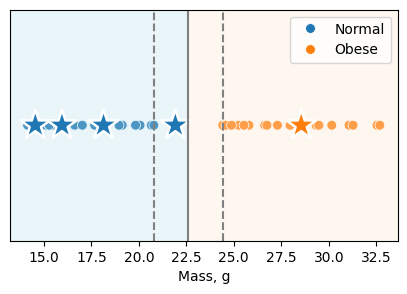

In [ ]:
x_test = np.random.uniform(14, 30, 5)


def classify(x, threshold=21.5):
    y = np.zeros_like(x)
    y[x > threshold] = 1
    return y


plt.figure(figsize=(5, 3))
ax = plot_data_1d(
    x, y, total_len=total_len, threshold=threshold, margin=[normal_limit, obese_limit]
)
ax = plot_data_1d(
    x_test,
    classify(x_test, threshold=threshold),
    total_len=total_len,
    s=500,
    marker="*",
)

Получилось не плохо.

## Многомерная классификация

Мы умеем решать задачу классификации в одномерном случае. В многомерном случае попробуем свести задачу к одномерной. Для этого мы будем подбирать вектор весов и смещение чтобы точки преобразовывались, как на картинке:

<img src ="https://ml.gan4x4.ru/msu/dev-2.1/L02/out/svm_hard_margin.png" width="1000">

Подобрать такое преобразование в многомерной задаче — значит провести **разделяющую гиперплоскость** так, чтобы:
1. Объекты разных классов лежали **по разные** стороны от этой плоскости.
2. **Ближайшие** к плоскости **объекты** были от нее как можно **дальше**.



**Гиперплоскость однозначно задается вектором нормали $\vec w$ и смещением $b$.** Скалярное произведение на вектор весов $\vec w$ - это проекция на вектор нормали разделяющей плоскости. Побирая $\vec w$ и $b$ мы сводим задачу у одномерной.

Зазор между классами будет опираться в объекты, которые мы назовем **опорными векторами**. Именно эти объекты проектируются преобразованием в точки 1 и -1, это обеспечивает удобство при математической записи преобразования и поиске решения (мера проекции опорного вектора = 1). Для более глубокого понимания SVM рекомендуем видео:
* [[video] 📺 MIT: Support Vector Machines](https://www.youtube.com/watch?v=_PwhiWxHK8o)

Математика Support Vector Machines (в которую мы не будем погружаться в рамках этой лекции) крутится вокруг этих объектов. Функцию потерь и решающее правило [можно расписать ✏️[blog]](https://www.geeksforgeeks.org/dual-support-vector-machine/) через скалярное произведение с опорными векторами. Грубо мы можем сказать, что скалярное произведение - это ["мера подобия" 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%92%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C#:~:text=%D0%9A%D0%BE%D1%81%D0%B8%D0%BD%D1%83%D1%81%D0%BD%D0%BE%D0%B5%20%D1%81%D1%85%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%E2%80%94%20%D1%8D%D1%82%D0%BE%20%D0%BC%D0%B5%D1%80%D0%B0%20%D1%81%D1%85%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%B0,%D0%B8%D0%B7%D0%BC%D0%B5%D1%80%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%BA%D0%BE%D1%81%D0%B8%D0%BD%D1%83%D1%81%D0%B0%20%D1%83%D0%B3%D0%BB%D0%B0%20%D0%BC%D0%B5%D0%B6%D0%B4%D1%83%20%D0%BD%D0%B8%D0%BC%D0%B8.) между векторами и "сравнивая" классифицируемый объект с опорными векторами мы можем определить его класс.

Рассмотрим задачу классификации мышей, в которой мы измерили не только вес мышей, но и их длину от хвоста до носа.

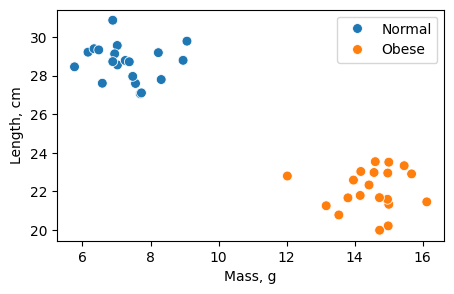

In [ ]:
from sklearn.datasets import make_blobs


def generate_2d_data(total_len=40):
    x, y = make_blobs(n_samples=total_len, centers=2, random_state=42)
    x[:, 0] += 10
    x[:, 1] += 20
    return x, y


total_len = 40
x, y = generate_2d_data(total_len=total_len)

fig = plt.figure(figsize=(5, 3))
ax = sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, s=50)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Normal", "Obese"])
ax.set(xlabel="Mass, g", ylabel="Length, cm")
plt.show()

Применим к мышкам метод `svm` из библиотеки Sklearn:

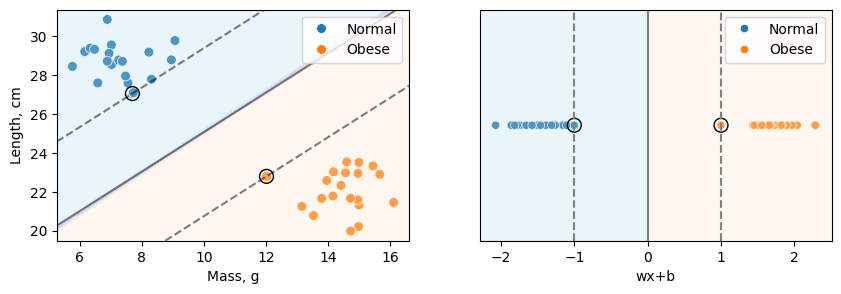

In [ ]:
from sklearn import svm

# Code for illustration, later we will understand how it works
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(x, y)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# first fig
sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, s=50, ax=axs[0])
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, ["Normal", "Obese"])
axs[0].set(xlabel="Mass, g", ylabel="Length, cm")

# plot the decision function
delta = 0.5
# create grid to evaluate model
YY, XX = np.meshgrid(
    np.linspace(x[:, 1].min() - delta, x[:, 1].max() + delta, 30),
    np.linspace(x[:, 0].min() - delta, x[:, 0].max() + delta, 30),
)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)
pred = np.sign(Z)
axs[0].contourf(XX, YY, pred, alpha=0.3, cmap=custom_cmap)

# plot decision boget_xlimundary and margins
axs[0].contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5,
    linestyles=["--", "-", "--"],
)
# plot support vectors
axs[0].scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)

# second fig
dec_val = clf.decision_function(x)
sns.scatterplot(x=dec_val, y=np.zeros(len(x)), hue=y, ax=axs[1])

x_lim, y_lim = axs[1].get_xlim(), axs[1].get_ylim()
XX, YY = np.meshgrid(
    np.linspace(x_lim[0], x_lim[1], 100), np.linspace(y_lim[0], y_lim[1], 100)
)
pred = np.sign(XX)
axs[1].contourf(XX, YY, pred, alpha=0.3, cmap=custom_cmap)

axs[1].axvline(0, color="grey")
axs[1].axvline(-1, color="grey", ls="dashed")
axs[1].axvline(1, color="grey", ls="dashed")
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, ["Normal", "Obese"])
axs[1].set(xlabel="wx+b",  yticks=[])

sv = clf.decision_function(clf.support_vectors_)
axs[1].scatter(
    sv, np.zeros_like(sv), s=100, linewidth=1, facecolors="none", edgecolors="k"
)
plt.show()

Круги - опопрные вектора. Пунктиром показан зазор.

**Практические советы по использованию SVM:**

* SVM делает **геометрическое разделение данных**, поэтому для адекватной работы модели важна **нормализация**.
* В случае **дисбаланса классов** полезно использовать параметры `class_weight` и `sample_weight` ([подробнее 🛠️[doc]](https://scikit-learn.org/stable/modules/svm.html#unbalanced-problems)).
* SVM работает и для классификации неразделимых данных (вводится ограничение, на сколько классы могут смешиваться, обычно за это отвечает параметр `C`).
* SVM может давать хорошее решение при небольшом количестве данных, в этом случае стоит попробовать **различные ядра** (про ядра вы узнаете ниже).

# Обобщенные линейные модели

## Полиномиальная модель

Данные не всегда могут быть **хорошо разделены (гипер)плоскостью**. Например: у нас есть данные по дозировке лекарства и 2 класса — пациенты, которые поправились, и те, которым лучше не стало.

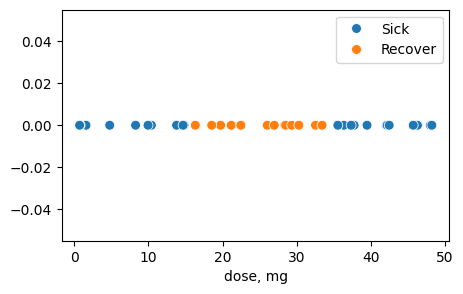

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


def generate_patients_data(total_len=40):
    x = np.random.uniform(0, 50, total_len)
    y = np.zeros_like(x)
    y[(x > 15) & (x < 35)] = 1
    return x, y


def plot_data(x, y, total_len=40, s=50):
    plt.figure(figsize=(5, 3))
    ax = sns.scatterplot(x=x, y=np.zeros(len(x)), hue=y, s=s)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Sick", "Recover"])
    ax.set(xlabel="dose, mg")
    return ax


total_len = 40
x, y = generate_patients_data(total_len=total_len)
ax = plot_data(x, y, total_len=total_len)
plt.show()

Соответственно, мы не можем найти такое пороговое значение, которое будет разделять наши классы на больных и здоровых, а, следовательно, и Support Vector Classifier работать тоже не будет.  Для начала давайте преобразуем наши данные таким образом, чтобы они стали 2-хмерными. В качестве значений по оси Y будем использовать дозу, возведенную в квадрат (**доза**$^2$).

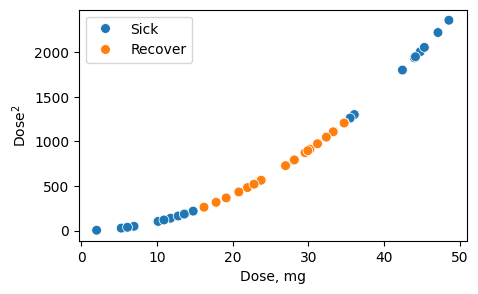

In [ ]:
def plot_data(x, y, total_len=40, s=50):
    plt.figure(figsize=(5, 3))
    ax = sns.scatterplot(x=x[0, :], y=x[1, :], hue=y, s=s)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Sick", "Recover"])
    ax.set(xlabel="Dose, mg")
    ax.set(ylabel="Dose$^2$")
    return ax


total_len = 40
x_1, y = generate_patients_data(total_len=total_len)
x_2 = x_1**2
x = np.vstack([x_1, x_2])

plot_data(x, y, total_len=40, s=50)
plt.show()

Теперь мы можем вновь использовать Support Vector Classifier для классификации.

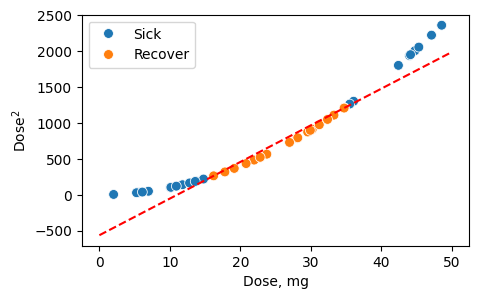

In [ ]:
plot_data(x, y, total_len=40, s=50)

x_arr = np.linspace(0, 50, 50)
xs = [x[0, :][y == 1].min(), x[0, :][y == 1].max()]
ys = [x[1, :][y == 1].min(), x[1, :][y == 1].max()]

# Calculate the coefficients.
coefficients = np.polyfit(xs, ys, 1)

# Let's compute the values of the line...
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_arr)

# ...and plot the points and the line
plt.plot(x_arr, y_axis, "r--")
plt.show()

## Kernel SVM

Основная идея **Kernel SVM** состоит в том, что **мы можем перейти в пространство большей размерности, в котором данные будут линейно разделимы**.

 ### Обоснование Kernel SVM

<img src="https://ml.gan4x4.ru/msu/dev-2.1/L02/out/svm_kernel_function.png" width="700">


Мы уже говорили, что **решающее правило SVM** можно записать через **скалярное произведение с опорными векторами**. В  Kernel SVM скалярное произведение заменяется на другую функцию подобия, которая называется **ядром/kernel**.

[Подробнее 📚[book]](https://people.csail.mit.edu/dsontag/courses/ml13/slides/lecture6.pdf).

### Примеры ядер

Для демонстрации возможностей Kernel SVM создадим датасет, который не разделяется линейными моделями. Для этого воспользуемся функцией `sklearn.datasets.make_circles`.

In [ ]:
from sklearn.datasets import make_circles

x, y = make_circles(n_samples=500, factor=0.3, noise=0.05, random_state=42)

Полученный датасет представляет собой две окружности с разными радиусами и общим центром, относящиеся к разным классам.

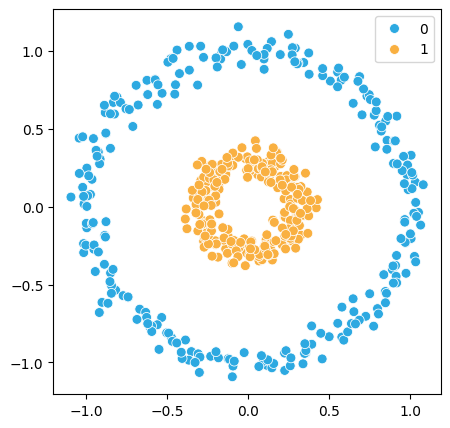

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.scatterplot(
    x=x[:, 0],
    y=x[:, 1],
    hue=y,
    s=50,
    ax=ax,
    palette=sns.color_palette(["#2DA9E1", "#F9B041"]),
)
plt.show()

Напишем функцию визуализации разделяющего правила для SVM модели:

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay


def plot_svm(x, y, clf):
    dull_cmap = ListedColormap(["#B8E1EC", "#FEE7D0"])
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        x,
        response_method="predict",
        cmap=dull_cmap,
        alpha=0.8,
        xlabel="feature 1",
        ylabel="feature 2",
        ax=ax,
    )

    sns.scatterplot(
        x=x[:, 0],
        y=x[:, 1],
        hue=y,
        s=50,
        ax=ax,
        palette=sns.color_palette(["#2DA9E1", "#F9B041"]),
    )
    plt.show()

Первое ядро, которое мы рассмотрим, линейное. Оно задается формулой:
$$\large K(\vec x_i, \vec x_j) = (\vec x_i, \vec x_j)$$

Линейным ядром является скалярное произведение векторов.

Линейное ядро не способно справиться с такой задачей:

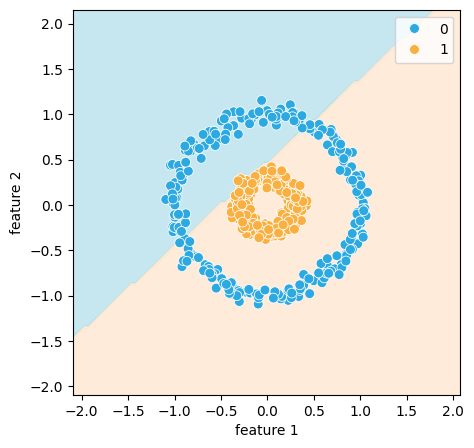

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel="linear")
clf.fit(x, y)
plot_svm(x, y, clf)

Следующее ядро, реализованное в библиотеке Sklearn — полиномиальное, оно задается формулой:
$$K(\vec x_i, \vec x_j) = (\gamma (\vec x_i, \vec x_j)+r)^d,$$
где $d$ — настраиваемый параметр: степень полинома `degree`.

Попробуем применить полиномиальное ядро к нашим данным:

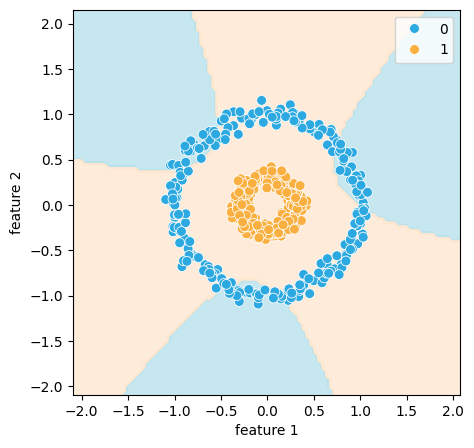

In [ ]:
clf = svm.SVC(kernel="poly")
clf.fit(x, y)
plot_svm(x, y, clf)

Полиномиальное ядро действует не совсем как полиномиальная модель.
У модели не получилось разделить данные. Это связано с тем, что значение `degree` по умолчанию равно 3, поставим степень полинома 2:

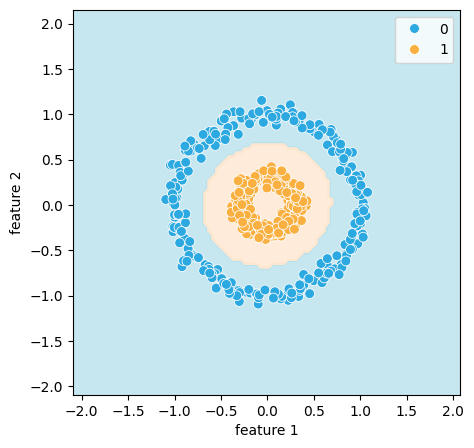

In [ ]:
clf = svm.SVC(kernel="poly", degree=2)
clf.fit(x, y)
plot_svm(x, y, clf)

Вывод, который тут стоит сделать: для получения **оптимального результата** бывает полезным **настроить параметры ядра** с учетом даных.

Самым  популярным ядром SVM является ядро радиальных базисных функций RBF, или гауссово ядро. Оно получено из гауссова  распределения, а гауссово распределение характерно для большого количества измеряемых величин. Данное ядро задается формулой:

$$\large K(\vec x_i, \vec x_j) = e^{-\gamma{||\vec x_i - \vec x_j||^2}}$$

Настраиваемыми параметрами модели являются `C` и `gamma`. `C` определяет степень гладкости поверхности принятия решений: чем больше `C`, тем сложнее поверхность и **выше вероятность переобучения** (про переобучение поговорим ниже), `gamma` определяет степень влияния одного обучающего примера на разделяющее правило ([подробнее 🛠️[doc]](https://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel)).

SVM может проверять пространства признаков бесконечного размера, если для такого пространства существует kernel function. RBF ядро как раз [соответствует 📚[book]](https://pages.cs.wisc.edu/~matthewb/pages/notes/pdf/svms/RBFKernel.pdf) такому случаю бесконечномерного пространства признаков.

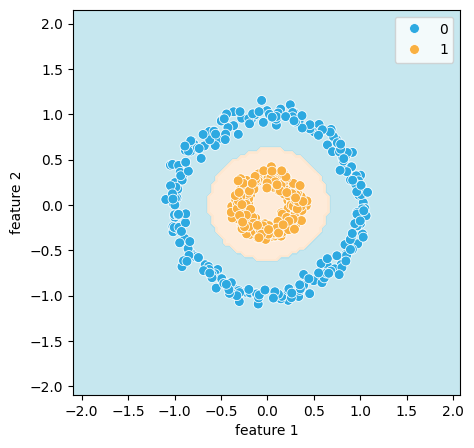

In [ ]:
clf = svm.SVC(kernel="rbf")
clf.fit(x, y)
plot_svm(x, y, clf)

Также в Sklearn реализовано `sigma` ядро. Оно интересно больше с исторической точки зрения, т.к. эквивалентно модели нейрона — Перцептрону, о котором вы узнаете на 5-й лекции. [На практике 🎓[article]](https://home.work.caltech.edu/~htlin/publication/doc/tanh.pdf) оно в большинстве случаев проигрывает RBF ядру.

$$\large K(\vec x_i, \vec x_j) = \tanh (\gamma(\vec x_i, \vec x_j)+r)$$